In [1]:
from shapes_dataset_generator import ShapesDatasetGenerator
import wandb
import matplotlib.pyplot as plt
from experiment import LightningVAE
from metrics import calculate_mcc
import torch
import numpy as np
from os import path

In [2]:
run = wandb.init()
artifact = run.use_artifact('adirtuval/lab_vae/model-3fb89i0i:v52', type='model')
artifact_dir = artifact.download()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: Currently logged in as: adirtuval. Use `wandb login --relogin` to force relogin


wandb:   1 of 1 files downloaded.  


In [2]:
sdg = ShapesDatasetGenerator(
    render_config={
        "background_color": "black",
        "sample_color": "blue",
        "canvas_size": 32,
        "anti_alias" : 1,
    }
)
model = LightningVAE.load_from_checkpoint('/cs/labs/yweiss/adirt/lab_project/vae-lab-project/artifacts/model-3fb89i0i:v52/model.ckpt').model
model = model.eval()

Hidden dims:  [8, 16, 32, 64]


In [105]:
samples, sources = sdg.generate(1000)
sources = sources.transpose(1, 0)
samples = torch.Tensor(samples).cuda().permute(0, 3, 1, 2) / 255

tensor([[-1.70, -1.68]])

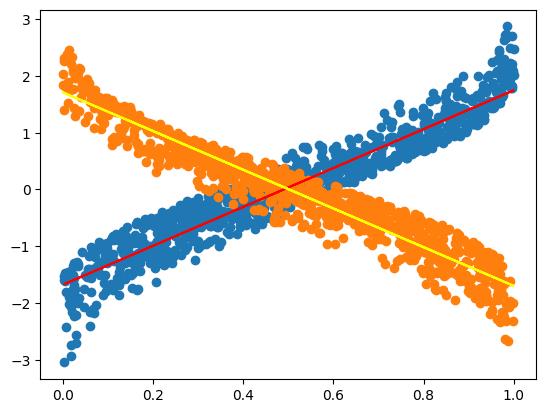

In [164]:
# model.learn_latent_mapping(sources, samples)
latents = model(samples)["latents"]
latents = latents.detach().cpu().permute(1, 0).numpy()
_, sort_idx, latents_sorted = calculate_mcc(latents, sources)
a0, b0 = np.polyfit(sources[0, :], latents_sorted[0, :], 1)
a1, b1 = np.polyfit(sources[1, :], latents_sorted[1, :], 1)
a = torch.Tensor([[a0, a1]])
b = torch.Tensor([[b0, b1]])
plt.scatter(sources[0, :], latents_sorted[0, :])
plt.scatter(sources[1, :], latents_sorted[1, :])
plt.plot(sources[0, :], a0 * sources[0, :] + b0, color='red')
plt.plot(sources[1, :], a1 * sources[1, :] + b1, color='yellow')
(torch.Tensor([[0, 1]]) * a + b)[:, sort_idx]


In [185]:
r = 10
xs = torch.linspace(0, 1, steps=r)
ys = torch.linspace(0, 1, steps=r)
x, y = torch.meshgrid(xs, ys, indexing='xy')
x = x.flatten()
y = y.flatten()
latents = torch.stack([x, y], dim=1)
latents = (latents * a + b)[:, sort_idx]
latents = latents.cuda()
reconstructed = model.decode(latents)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

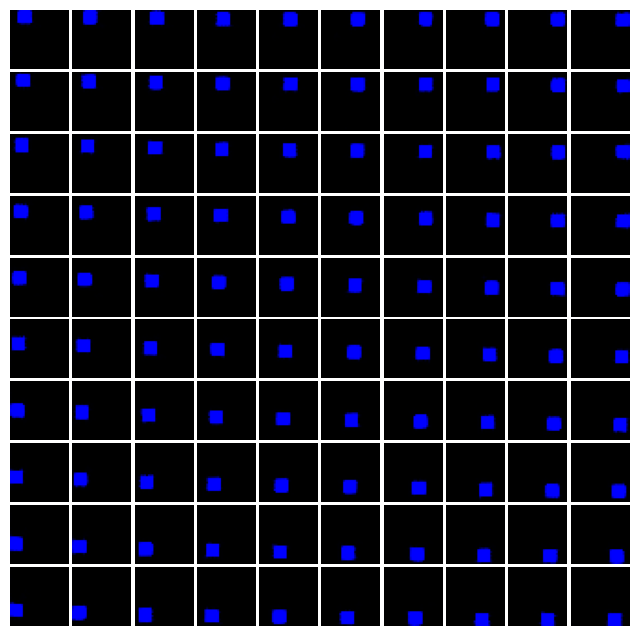

In [187]:
# Create a subplot with tight layout
fig, axes = plt.subplots(
    r, r, figsize=(8, 8), gridspec_kw={"wspace": 0.05, "hspace": 0.05}
)

# Loop through each image and plot it on the corresponding subplot
for i in range(r):
    for j in range(r):
        axes[i, j].imshow(
            reconstructed[(i * r) + j].permute(1, 2, 0).cpu().detach().numpy()
        )
        axes[i, j].axis("off")  # Hide axes for cleaner presentation (optional)

# Adjust layout (optional)
plt.tight_layout()

# Show the plot
plt.show()